In [1]:
import pandas as pd

In [2]:
# load the csv files
test = pd.read_csv("../data/raw_data/dreaddit-test.csv")
train = pd.read_csv("../data/raw_data/dreaddit-train.csv")

# concat all the data
df = pd.concat([train,test], ignore_index=True)
df.shape

(3553, 116)

In [3]:
test.shape

(715, 116)

In [4]:
train.shape

(2838, 116)

In [5]:
df.head(3)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1.521614e+09,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1.527010e+09,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1.535936e+09,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894


In [6]:
df.duplicated().sum()

0

In [7]:
df = df.rename(columns={"label":"stress"})

In [8]:
df.head(3)

,subreddit,post_id,sentence_range,text,id,stress,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1.521614e+09,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1.527010e+09,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1.535936e+09,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894


In [9]:
# export as csv file
df.to_csv('../data/clean_data/model_training.csv', index=False)

In [2]:
# reload the file
stress = pd.read_csv('../data/clean_data/model_training.csv')

In [3]:
stress.columns

Index(['subreddit', 'post_id', 'sentence_range', 'text', 'id', 'stress',
       'confidence', 'social_timestamp', 'social_karma', 'syntax_ari',
       ...
       'lex_dal_min_pleasantness', 'lex_dal_min_activation',
       'lex_dal_min_imagery', 'lex_dal_avg_activation', 'lex_dal_avg_imagery',
       'lex_dal_avg_pleasantness', 'social_upvote_ratio',
       'social_num_comments', 'syntax_fk_grade', 'sentiment'],
      dtype='object', length=116)

In [4]:
stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3553 entries, 0 to 3552
Columns: 116 entries, subreddit to sentiment
dtypes: float64(107), int64(5), object(4)
memory usage: 3.1+ MB


In [5]:
stress['stress'].value_counts()

# according to the value_counts, we can see that stress and no_stress groups are not very imbalance.

stress
1    1857
0    1696
Name: count, dtype: int64

# Preparation of text

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and get English stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\54189\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\54189\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\54189\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())  # Convert to lower case
    # Remove stopwords and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
    return ' '.join(lemmatized_tokens)



In [ ]:
# Apply preprocessing to the text data
stress['processed_text'] = stress['text'].apply(preprocess_text)

# Show the processed text
stress[['text', 'processed_text']].head()

# Model training - LogisticRegression

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

"TF-IDF vectorization transforms text into a numerical representation by measuring a word's frequency in a document against its rarity across the entire document corpus, making it understandable for machine learning models."

In [9]:
# Prepare data
X = stress['processed_text']
y = stress['stress']  # Using the 'stress' column as the target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a text classification pipeline with TF-IDF and Logistic Regression
pipeline = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

# Train the model
pipeline.fit(X_train, y_train)

# Predict on the test set
pred_lr = pipeline.predict(X_test)

# Evaluate the model
print(classification_report(y_test, pred_lr))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       323
           1       0.77      0.77      0.77       388

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



<Axes: >

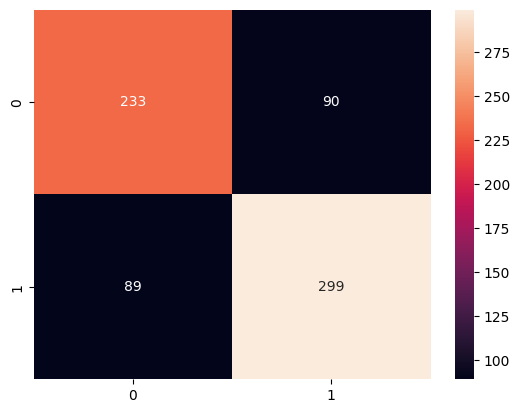

In [10]:
sns.heatmap(confusion_matrix(y_test, pred_lr), annot=True,fmt='g')

In [11]:
pipeline2 = make_pipeline(
    TfidfVectorizer(max_df=0.95, min_df=5, ngram_range=(1, 2), norm='l2', use_idf=True),
    LogisticRegression(max_iter=1000)
)

pipeline2.fit(X_train, y_train)


pred_lr2 = pipeline2.predict(X_test)


print(classification_report(y_test, pred_lr2))

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       323
           1       0.77      0.78      0.77       388

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



<Axes: >

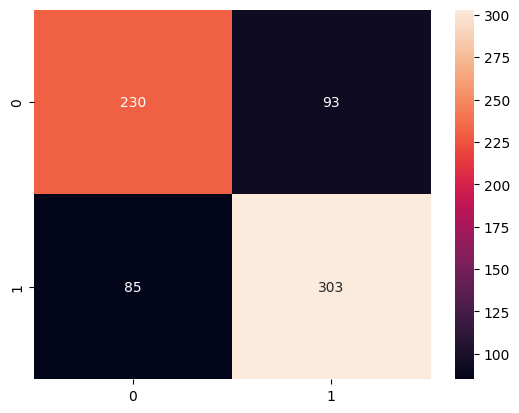

In [12]:
sns.heatmap(confusion_matrix(y_test, pred_lr2), annot=True,fmt='g')

In [13]:
pipeline3 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])

# Train the model
pipeline3.fit(X_train, y_train)

# Predict on the test set
pred_lr3 = pipeline3.predict(X_test)

# Evaluate the model
print(classification_report(y_test, pred_lr3))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       323
           1       0.77      0.77      0.77       388

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



## Grid search

In [14]:
param_grid = {
    'tfidf__max_df': (0.5, 0.75, 1.0),
    'tfidf__ngram_range': [(1, 1), (1, 2)],  
    # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'clf__C': [0.01, 0.1, 1, 10, 100],  
    # Logistic regression regularization parameter
    'clf__solver': ['liblinear', 'lbfgs']  
    # Different algorithms for logistic regression
}

In [15]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(pipeline3, param_grid, cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100],
                         'clf__solver': ['liblinear', 'lbfgs'],
                         'tfidf__max_df': (0.5, 0.75, 1.0),
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=1)

In [16]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'clf__C': 1, 'clf__solver': 'liblinear', 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1), 'tfidf__use_idf': True}
Best cross-validation score: 0.74
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       323
           1       0.77      0.77      0.77       388

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



<Axes: >

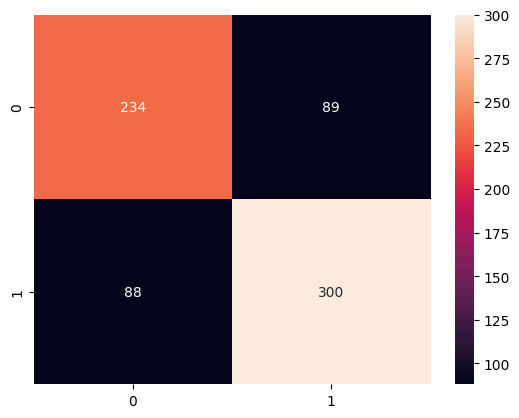

In [35]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,fmt='g')

## Random Search

In [17]:
from scipy.stats import uniform, randint

param_distributions = {
    'tfidf__max_df': uniform(0.7, 0.3),  # max_df will be between 0.7 and 1.0
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__use_idf': [True, False],
    'clf__C': uniform(0.01, 10),  # C will be between 0.01 and 10.01
    'clf__solver': ['liblinear', 'lbfgs']
}

In [18]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    pipeline3, param_distributions=param_distributions, 
    n_iter=100,  # number of parameter settings sampled
    cv=5, verbose=2, random_state=42, n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('clf', LogisticRegression())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'clf__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B3D48053D0>,
                                        'clf__solver': ['liblinear', 'lbfgs'],
                                        'tfidf__max_df': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001B3D2328770>,
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)],
                                        'tfidf__use_idf': [True, False]},
                   random_state=42, verbose=2)

In [19]:
print("Best parameters:", random_search.best_params_)
print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

# Evaluate on the test set
y_pred2 = random_search.predict(X_test)
print(classification_report(y_test, y_pred2))

Best parameters: {'clf__C': 1.2116464780564218, 'clf__solver': 'liblinear', 'tfidf__max_df': 0.7348217921520748, 'tfidf__ngram_range': (1, 1), 'tfidf__use_idf': True}
Best cross-validation score: 0.74
              precision    recall  f1-score   support

           0       0.72      0.72      0.72       323
           1       0.77      0.77      0.77       388

    accuracy                           0.75       711
   macro avg       0.74      0.74      0.74       711
weighted avg       0.75      0.75      0.75       711



# Model training - SVM & RandomForest

We only used the random search for svm and randomforest to find a good enough solution much faster.

In [20]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [21]:
# Create SVM and Random Forest classification pipelines
svm_pipeline = make_pipeline(TfidfVectorizer(), SVC(probability=True))
rf_pipeline = make_pipeline(TfidfVectorizer(), RandomForestClassifier())

In [ ]:

# Define the parameter grid for SVM
param_grid_svm = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto'],
}

# Initialize the Grid Search model
grid_search_svm = GridSearchCV(svm_pipeline, param_grid_svm, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_svm.fit(X_train, y_train)


In [23]:
from scipy.stats import expon, reciprocal

# Define the parameter distribution for SVM
param_distributions_svm = {
    'svc__C': reciprocal(0.1, 100),
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': expon(scale=1.0),
}

In [ ]:
print("Best parameters:", grid_search_svm.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_svm.best_score_))

y_pred_svm = grid_search_svm.predict(X_test)
print(classification_report(y_test, y_pred_svm))

In [21]:
# Train the SVM model
svm_pipeline.fit(X_train, y_train)
# Predict on the test set for SVM
pred_svm = svm_pipeline.predict(X_test)
# Evaluate the SVM model
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       323
           1       0.78      0.77      0.77       388

    accuracy                           0.75       711
   macro avg       0.75      0.75      0.75       711
weighted avg       0.75      0.75      0.75       711



<Axes: >

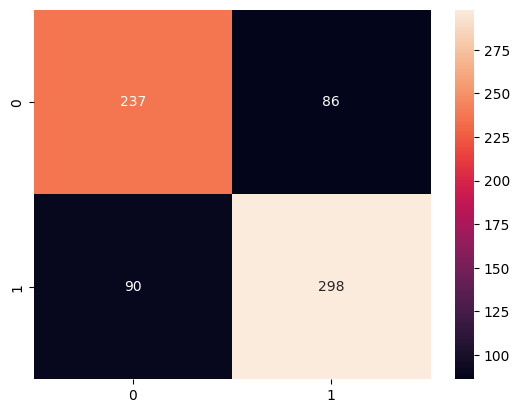

In [22]:
sns.heatmap(confusion_matrix(y_test, pred_svm), annot=True,fmt='g')

In [ ]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'randomforestclassifier__n_estimators': [100, 200, 500],
    'randomforestclassifier__max_depth': [10, 20, 30],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}

In [ ]:
# Initialize the Grid Search model
grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_rf.fit(X_train, y_train)


In [ ]:
print("Best parameters:", grid_search_rf.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_rf.best_score_))

y_pred_rf = grid_search_rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))

In [23]:
# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)
# Predict on the test set for Random Forest
pred_rf = rf_pipeline.predict(X_test)
# Evaluate the Random Forest model
print(classification_report(y_test, pred_rf))

              precision    recall  f1-score   support

           0       0.79      0.64      0.71       323
           1       0.74      0.86      0.79       388

    accuracy                           0.76       711
   macro avg       0.76      0.75      0.75       711
weighted avg       0.76      0.76      0.75       711



<Axes: >

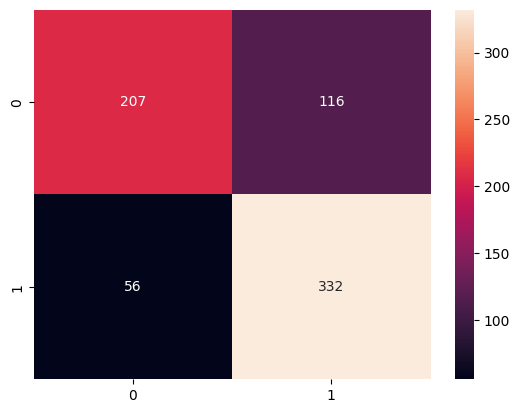

In [24]:
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True,fmt='g')

# Pretrained Model - Bert

In [5]:
# Extract relevant columns for text classification: text and stress label
data_subset = stress[['text', 'stress']]
data_subset.head(3)

,text,stress
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1


In [6]:
data_subset.dtypes

text      object
stress     int64
dtype: object

In [8]:
# Import required modules from transformers
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
import torch

In [9]:
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Function to tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

In [11]:
# Preparing datasets
data_subset['split'] = 'train'
train_texts, test_texts, train_labels, test_labels = train_test_split(data_subset['text'], data_subset['stress'], test_size=0.2, random_state=42)
train_dataset = {'text': train_texts, 'labels': train_labels}
test_dataset = {'text': test_texts, 'labels': test_labels}

C:\Users\54189\AppData\Local\Temp\ipykernel_13464\1982780189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['split'] = 'train'


In [12]:
train_encodings = tokenize_function(train_dataset)
test_encodings = tokenize_function(test_dataset)

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:
# Convert to torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = Dataset(train_encodings, train_labels.tolist())
test_dataset = Dataset(test_encodings, test_labels.tolist())

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"
)


In [ ]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [22]:
# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\54189\AppData\Local\Temp\ipykernel_27556\2676757777.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_subset['split'] = 'train'


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

# Result

Based on the comparison, the results of the LR (Logistic Regression) model and the SVM (Support Vector Machine) model are almost identical. Considering the aspect of interpretability, the LR model was ultimately chosen.

In [25]:
from joblib import dump, load

# save the model as joblib file
dump(grid_search, 'text_stress_lrmodel.joblib')


['text_stress_lrmodel.joblib']

# Apply the model to the clean_reviews.csv

In [16]:
# load csv file
reviews_data = pd.read_csv('../data/clean_data/clean_reviews.csv')
reviews_data.head(3)

,title_id,title,review_no,review
0,111,five feet apart,1,[3.5] There’s some disagreement within the CF ...
1,111,five feet apart,2,Edit: For the love of God I wrote this review ...
2,111,five feet apart,3,Can't say I'm surprised I didn't enjoy this bo...


In [17]:
# preparation of review text
# apply preprocessing to the text
reviews_data['processed_text'] = reviews_data['review'].apply(preprocess_text)
reviews_data[['review', 'processed_text']].head(3)

,review,processed_text
0,[3.5] There’s some disagreement within the CF ...,disagreement within cf community whether book ...
1,Edit: For the love of God I wrote this review ...,edit love god wrote review two year ago still ...
2,Can't say I'm surprised I didn't enjoy this bo...,ca say surprised enjoy book part goodreads rea...


In [18]:
from joblib import dump, load

In [19]:
# load the model
model = load('text_stress_lrmodel.joblib')

In [20]:
reviews_data['predicted_stress'] = model.predict(reviews_data['processed_text'])
reviews_data[['processed_text', 'predicted_stress']].head()

,processed_text,predicted_stress
0,disagreement within cf community whether book ...,0
1,edit love god wrote review two year ago still ...,0
2,ca say surprised enjoy book part goodreads rea...,1
3,subjected mental emotional pain could also def...,1
4,two thing start really really really wanted li...,1


In [21]:
reviews_data['predicted_stress'].value_counts()

predicted_stress
0    14980
1     1880
Name: count, dtype: int64

In [22]:
# save the result
reviews_data.to_csv('../data/clean_data/reviews_with_stress.csv')